# Lecture 7
-------------------
## Classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns

from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy import stats
#in response to: module 'scipy.stats' has no attribute 'chisqprob' 
#stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

from scipy import special
%matplotlib inline
sns.set_style('white')

%precision 3

'%.3f'

## Datasets

### Load data

In [2]:
#1. default data from ISLR

# In R, we exported the dataset from package 'ISLR' to an Excel file
df = pd.read_csv('../data/Default.csv',index_col=0)

#2. Titanic

titanic = sns.load_dataset('titanic')

df.head(3)

,default,student,balance,income
1,No,No,729.526495,44361.62507
2,No,Yes,817.180407,12106.13470
3,No,No,1073.549164,31767.13895


In [3]:
# Note: factorize() returns two objects: a label array and an array with the unique values.
df.default.factorize()

(array([0, 0, 0, ..., 0, 0, 0]), Index(['No', 'Yes'], dtype='object'))

In [4]:
# We are only interested in the first object. 
df['default2'] = df.default.factorize()[0]
df['student2'] = df.student.factorize()[0]

### Data Exploration

**Figure 4.1 (ISLR) - Default data set**

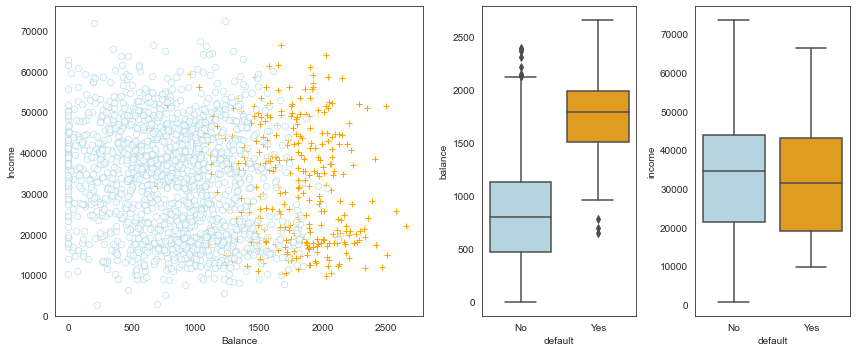

In [5]:
fig = plt.figure(figsize=(12,5))
gs = mpl.gridspec.GridSpec(1, 4)
ax1 = plt.subplot(gs[0,:-2])
ax2 = plt.subplot(gs[0,-2])
ax3 = plt.subplot(gs[0,-1])

# Take a fraction of the samples where target value (default) is 'no'
df_no = df[df.default2 == 0].sample(frac=0.15)
# Take all samples  where target value is 'yes'
df_yes = df[df.default2 == 1]
df_ = df_no.append(df_yes)

ax1.scatter(x=df_[df_.default == 'Yes'].balance, y=df_[df_.default == 'Yes'].income, s=40, c='orange', marker='+',
            linewidths=1)
ax1.scatter(x=df_[df_.default == 'No'].balance, y=df_[df_.default == 'No'].income, s=40, marker='o', linewidths=1,
            edgecolors='lightblue', facecolors='white', alpha=.6)

ax1.set_ylim(ymin=0)
ax1.set_ylabel('Income')
ax1.set_xlim(xmin=-100)
ax1.set_xlabel('Balance')

c_palette = {'No':'lightblue', 'Yes':'orange'}
sns.boxplot(x='default', y='balance', data=df, orient='v', ax=ax2, palette=c_palette)
sns.boxplot(x='default', y='income', data=df, orient='v', ax=ax3, palette=c_palette)
gs.tight_layout(plt.gcf())

-----------------------------------------------
## Logistic Regression

Recall our fit to the Titanic data from last week and the dilemma that some predictions and interpretations (such as the intercept) often led to survival probabilities outside the range $[0,1]$.


In [6]:
est = smf.ols('survived ~ age + C(pclass) + C(sex)', titanic).fit()
print(est.summary().tables[1])

                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.1250      0.051     22.202      0.000       1.026       1.225
C(pclass)[T.2]    -0.2077      0.042     -4.983      0.000      -0.290      -0.126
C(pclass)[T.3]    -0.4066      0.038    -10.620      0.000      -0.482      -0.331
C(sex)[T.male]    -0.4795      0.031    -15.608      0.000      -0.540      -0.419
age               -0.0055      0.001     -5.039      0.000      -0.008      -0.003


In [7]:
est = smf.logit('survived ~ age + C(pclass) + C(sex)', data=titanic)
print(est.fit().summary())

Optimization terminated successfully.
         Current function value: 0.453279
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               survived   No. Observations:                  714
Model:                          Logit   Df Residuals:                      709
Method:                           MLE   Df Model:                            4
Date:                Sun, 30 May 2021   Pseudo R-squ.:                  0.3289
Time:                        20:26:47   Log-Likelihood:                -323.64
converged:                       True   LL-Null:                       -482.26
Covariance Type:            nonrobust   LLR p-value:                 2.074e-67
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.7770      0.401      9.416      0.000       2.991       4.563
C(pclass)[T.2]   

This is not the only shortcoming of **linear** regression (LR) for binary outcomes! Other problems include heteroskedasticity and incorrect scaling of probabilities even inside the range $[0,1]$.

One solution is to transform the linear output of the (LR) to an S-shape via the **sigmoidal** function $s(z) = 1/(1+exp(-z))$, which is the strategy taken by **logistic regression** (example: Figure 4.2 from the ISLR book):

coefficients:  [[0.005]]
intercept : [-10.651]


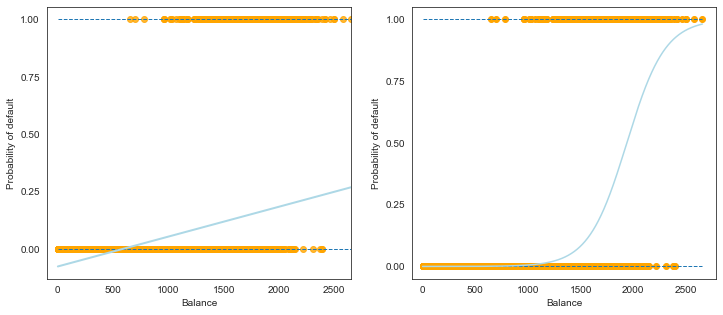

In [8]:
##first the sklearn module LogisticRegression
X_train = df.balance.values.reshape(-1,1) 
y = df.default2

# Create array of test data. Calculate the classification probability
# and predicted classification.
X_test = np.arange(df.balance.min(), df.balance.max()).reshape(-1,1)

clf = skl_lm.LogisticRegression(solver='newton-cg')
clf.fit(X_train,y)
#compare to Table 4.1 which was obtained with R:
print('coefficients: ',clf.coef_)
print('intercept :', clf.intercept_)

prob = clf.predict_proba(X_test)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
# Left plot
sns.regplot(x=df.balance, y=df.default2, order=1, ci=None,
            scatter_kws={'color':'orange'},
            line_kws={'color':'lightblue', 'lw':2}, ax=ax1)
# Right plot
ax2.scatter(x=X_train, y=y, color='orange')
ax2.plot(X_test, prob[:,1], color='lightblue')

for ax in fig.axes:
    ax.hlines(1, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.hlines(0, xmin=ax.xaxis.get_data_interval()[0],
              xmax=ax.xaxis.get_data_interval()[1], linestyles='dashed', lw=1)
    ax.set_ylabel('Probability of default')
    ax.set_xlabel('Balance')
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1.])
    ax.set_xlim(xmin=-100)

In [9]:
# now statsmodels:
#X_train = sm.add_constant(df.balance)
#est = smf.Logit(y.ravel(), X_train).fit()

est = smf.logit('default2 ~ balance', data=df)
print(est.fit().summary())

Optimization terminated successfully.
         Current function value: 0.079823
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:               default2   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9998
Method:                           MLE   Df Model:                            1
Date:                Sun, 30 May 2021   Pseudo R-squ.:                  0.4534
Time:                        20:26:48   Log-Likelihood:                -798.23
converged:                       True   LL-Null:                       -1460.3
Covariance Type:            nonrobust   LLR p-value:                6.233e-290
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -10.6513      0.361    -29.491      0.000     -11.359      -9.943
balance        0.0055      0

In [10]:
#Mini Tasks: fit a logistic regression to the Titanic data
#Try to make sense of the coefficients!
est = smf.logit('survived ~  C(pclass) + C(sex)', data=titanic)
print(est.fit().summary().tables[1])

Optimization terminated successfully.
         Current function value: 0.464023
         Iterations 6
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          2.2971      0.219     10.490      0.000       1.868       2.726
C(pclass)[T.2]    -0.8380      0.245     -3.424      0.001      -1.318      -0.358
C(pclass)[T.3]    -1.9055      0.214     -8.898      0.000      -2.325      -1.486
C(sex)[T.male]    -2.6419      0.184    -14.350      0.000      -3.003      -2.281


In [11]:
pHat = est.fit().predict()
pred = pHat > 0.5
pd.crosstab(pred, titanic.survived)

Optimization terminated successfully.
         Current function value: 0.464023
         Iterations 6


survived,0,1
row_0,,
False,468,109
True,81,233


### Coefficients as Odds

For "normal regression" we know that the value of $\beta_j$ simply gives us $\Delta y$ if $x_j$ is increased by one unit.

In order to fully understand the exact meaning of the coefficients for a LR model we need to first warm up to the definition of a **link function** and the concept of **probability odds**.

Using linear regression as a starting point

$$
y_i = \beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i} + \ldots +\beta_k x_{k,i} + \epsilon_i
$$

we modify the right hand side such that (i) the model is still basically a linear combination of the $x_j$s but (ii) the output is -like a probability- bounded between 0 and 1. This is achieved by "wrapping" a sigmoid function $s(z) = 1/(1+exp(-z))$ around the weighted sum of the $x_j$s:

$$
y_i = s(\beta_0 + \beta_1 x_{1,i} + \beta_2 x_{2,i} + \ldots +\beta_k x_{k,i} + \epsilon_i)
$$

The sigmoid function, depicted below to the left, transforms the real axis to the interval $(0;1)$ and can be interpreted as a probability.

<img src="../figures/ISLR-Fig4-2.png" width=600>

The inverse of the sigmoid is the *logit* (depicted above to the right), which is defined as $log(p/(1-p))$. For the case where p is a probability we call the ratio $p/(1-p)$ the **probability odds**. Thus, the logit is the log of the odds and logistic regression models these *log-odds* as a linear combination of the values of x.

Finally, we can interpret the coefficients directly: the odds of a positive outcome are multiplied by a factor of $exp(\beta_j)$ for every unit change in $x_j$.
(In that light, logistic regression is reminiscient of linear regression with logarithmically transformed dependent variable which also leads to multiplicative rather than additive effects.)

Summary

$$
p(x) = \frac{e^{\beta_0 + \beta_1 x_1 + \ldots + \beta_k x_k}}{1 + e^{\beta_0 + \beta_1 x_1 + \ldots + \beta_k x_k}}
$$
Odds 
$$
\frac{p(x)}{1-p(x)} = e^{\beta_0 + \beta_1 x_1 + \ldots + \beta_k x_k}
$$

This post has a more detailed view on the interpretations of the coefficients:

https://blog.hwr-berlin.de/codeandstats/interpretation-of-the-coefficients-in-logistic-regression/

#### Comments

1. When your data are **linearly separable** there is (ironically) a fitting problem ! See iris example below
2. *Logistic regression preserves the marginal probabilities.* 
The sum of the predicted probability scores for any subgroup of the training data (which includes all of it) will be equal to the number of positives.

3. *What is deviance ?*
Deviance (also referred to as *log loss*) is a measure of how well the model fits the data. It is 2 times the negative log likelihood of the dataset, given the model. 
$$
dev = - \sum_i{y_i \cdot \log p_i + (1-y_i) \cdot \log (1-p_i)}
$$
In Python, you can use the log_loss function from scikit-learn, with documentation found [here](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html).
If you think of deviance as analogous to variance, then the null deviance is similar to the variance of the data around the average rate of positive examples. The residual deviance is similar to the variance of the data around the model. As an exercise we will calculate the deviances in a homework.
4. **Pseudo $R^2$** [McFadden's $R^2$](http://thestatsgeek.com/2014/02/08/r-squared-in-logistic-regression/) is defined as $1−LL_{mod}/LL_0$, where $LL_{mod}$ is the log likelihood value for the fitted model and $LL_{0}$ is the log likelihood for the null model which includes only an intercept as predictor (so that every individual is predicted the same probability of 'success'). 
    * For a logistic regression model the log likelihood value is always negative (because the likelihood contribution from each observation is a probability between 0 and 1). If your model doesn't really predict the outcome better than the null model, $LL_{mod}$ will not be much larger than $LL_{0}$ , and so $LL_{mod}/LL_0 \sim 1$ , and McFadden's pseudo-R2 is close to 0 (your model has no predictive value). 
    * Conversely if your model was really good, those individuals with a success (1) outcome would have a fitted probability close to 1, and vice versa for those with a failure (0) outcome. In this case if you go through the likelihood calculation the likelihood contribution from each individual for your model will be close to zero, such that $LL_{mod}$ is close to zero, and McFadden's pseudo-R2 squared is close to 1, indicating very good predictive ability.

In [12]:
def logloss(true_label, predicted, eps=1e-15):
    p = np.clip(predicted, eps, 1 - eps)
    if true_label == 1:
        return -np.log(p)
    else:
        return -np.log(1 - p)

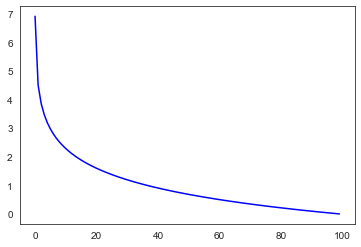

In [13]:
p= np.linspace(0.001,1,100)#.reshape(-1,1)
plt.plot(logloss(1,p), "b-");

### Think Stats Data

The NSFG dataset includes 244 variables about
each pregnancy and another 3087 variables about each respondent. Maybe some of those variables have predictive power. To 
nd out which ones are most useful, why not try them all?
Testing the variables in the pregnancy table is easy, but in order to use the variables in the respondent table, we have to match up each pregnancy with a respondent. In theory we could iterate through the rows of the pregnancy table, use the caseid to find the corresponding respondent, and copy the values from the correspondent table into the pregnancy table. But that would be slow.

A better option is to recognize this process as a join operation as defined in SQL and other relational database languages ([see](https://en.wikipedia.org/wiki/Join_(SQL))). Join is implemented as a DataFrame method, so we can perform the operation like this:

do not run this cell, for completeness, I show how the joined dataframe was created:

    from __future__ import print_function, division
    import numpy as np
    import nsfg

    preg = pd.read_hdf('../data/pregNSFG.h5', 'df')
    #only look at live births
    live = preg[preg.outcome == 1]

    live = live[live.prglngth>30]
    resp = nsfg.ReadFemResp()
    resp.index = resp.caseid
    join = live.join(resp, on='caseid', rsuffix='_r')
    #save to native python format:
    #http://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.DataFrame.to_hdf.html
    join.to_hdf('JoinedpregNSFG.h5', key='df', format='table',complevel =9)


In [ ]:
live = pd.read_hdf('../data/JoinedpregNSFG.h5','df')
live.head()

In [ ]:
#define first babies
firsts = live[live.birthord == 1]
#and all others:
others = live[live.birthord != 1]

In [ ]:
# from this discussion, it seems that statsmodels still uses the defunct
# chisqprob, so we have to define it ourselves:
# https://github.com/statsmodels/statsmodels/issues/3931
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
stats.chisqprob(10,3)

The mother's age seems to have a small, non significant effect.

In [ ]:
live['boy'] = (live.babysex==1).astype(int)
SexvsAge = smf.logit('boy ~ agepreg', data=live)
results = SexvsAge.fit()
print(results.summary())

In [ ]:
live["fmarout5"].value_counts()

### The Trivers-Willard hypothesis

**Exercise 11.2** The Trivers-Willard hypothesis suggests that for many mammals the sex ratio depends on \maternal condition"; that is, factors like the mother's age, size, health, and social status. [See](https://en.wikipedia.org/wiki/Trivers-Willard_hypothesis).
Some studies have shown this effect among humans, but results are mixed.
As an exercise, use a data mining approach to test the other variables in the pregnancy and respondent files. 

In the solution for exercise 11.2 the author uses a data mining approach to find the "best" model:

(Task: can we find out the meaning of the 2 new variables??)

In [ ]:
formula='boy ~ agepreg + fmarout5==5 + infever==1'
model = smf.logit(formula, data=live)
results = model.fit()
print(results.summary())

### Tasks

1. Compute the ROC curve and AUC for the NSFG data
2. Use cross validation to estimate some accuracy measure of classification for the 
    * Titanic survival
    * sex prediction for the NSFG data
3. Translate the coefficient for Pclass 3 into both odds and probability of survival (compared to the reference level Pclass 1).
4. Compute the survival probability of the first passenger in the data set.

In [14]:
import patsy 

y, X = patsy.dmatrices('survived ~ age + C(pclass) + C(sex)', titanic)
#y = titanic["survived"]

In [15]:
from sklearn.model_selection import cross_val_score
clf = skl_lm.LogisticRegression() # solver='newton-cg')

cv_results = cross_val_score(clf, X, np.ravel(y), cv=10)
print(np.round(cv_results,2))


[0.78 0.74 0.81 0.88 0.75 0.79 0.79 0.73 0.82 0.82]


### The Iris dataset

<img src="../figures/irisDataCamp.png" width=600>

(150, 4)


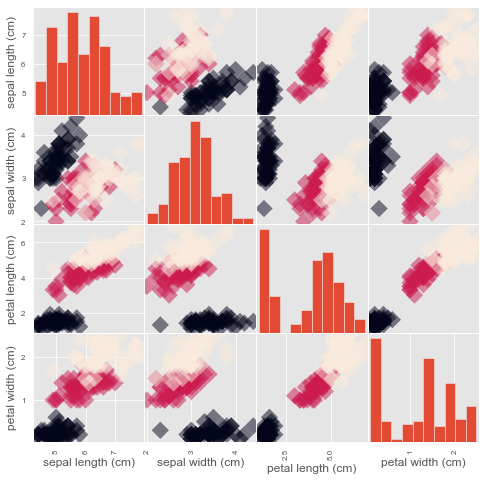

In [16]:
from sklearn import datasets

plt.style.use('ggplot')
iris = datasets.load_iris()
print(iris.data.shape)

X = iris.data
y = iris.target
df = pd.DataFrame(X, columns=iris.feature_names)
_ = pd.plotting.scatter_matrix(df, c = y, figsize = [8, 8],s=150, marker = 'D');

Looks like we could build a perfect classifier with just *petal width* ?

<img src="../figures/irisDataCampPairwise.png" width=600>

In [17]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [18]:
df["setosa"]= (y==0)
df.head()
df.columns

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)', 'setosa'],
      dtype='object')

In [19]:
X = iris["data"][:,3:]  # petal width

logit = sm.Logit((iris["target"]==0).astype(np.int), X)
logit.fit().params

Optimization terminated successfully.
         Current function value: 0.354801
         Iterations 7


array([-1.847])

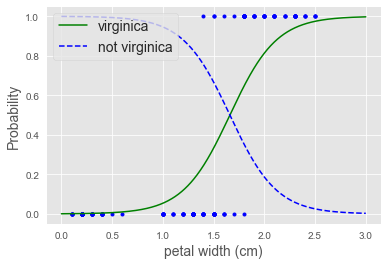

array([1, 0])

In [20]:
#sklearn
from sklearn.linear_model import LogisticRegression

def LogReg(xCol=3, target=2,penalty="l2"):
    X = iris["data"][:,xCol:]  # petal width
    y = (iris["target"]==target).astype(np.int)

    log_reg = LogisticRegression(penalty=penalty)
    log_reg.fit(X,y)

    X_new = np.linspace(0,3,1000).reshape(-1,1)
    y_proba = log_reg.predict_proba(X_new)

    flowerType=["setosa", "versicolor", "virginica"]
 
    plt.plot(X,y,"b.")
    plt.plot(X_new,y_proba[:,1],"g-",label=flowerType[target])
    plt.plot(X_new,y_proba[:,0],"b--",label="not " + flowerType[target])
    plt.xlabel(iris.feature_names[xCol], fontsize=14)
    plt.ylabel("Probability", fontsize=14)
    plt.legend(loc="upper left", fontsize=14)
    plt.show()
    
    return log_reg

log_reg = LogReg()

log_reg.predict([[1.7],[1.5]])

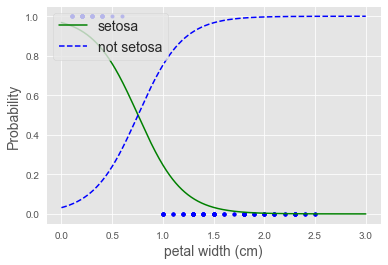

In [21]:
log_reg = LogReg(target=0)

----------------------------------------------------------
## Other Classifiers

### K Nearest Neighbors

In [22]:
from sklearn.neighbors import KNeighborsClassifier
iris = datasets.load_iris()
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(iris['data'], iris['target'])



KNeighborsClassifier(n_neighbors=6)

Task: Split the iris data into training and test. Predict on test

In [23]:
#prediction = knn.predict(X_test)
#print('Prediction {}’.format(prediction))

### Multinomial Logistic Regression

In [24]:
import statsmodels.api as st
#different way of importing data
iris = st.datasets.get_rdataset('iris', 'datasets')
 
y = iris.data.Species
 
y.head(3)

x = iris.data.iloc[:, 0]
 
x = st.add_constant(x, prepend = False)
 
x.head()

,Sepal.Length,const
0,5.1,1.0
1,4.9,1.0
2,4.7,1.0
3,4.6,1.0
4,5.0,1.0


In [25]:
mdl = st.MNLogit(y, x)
 
mdl_fit = mdl.fit()

print(mdl_fit.summary())

Optimization terminated successfully.
         Current function value: 0.606893
         Iterations 8
                          MNLogit Regression Results                          
Dep. Variable:                Species   No. Observations:                  150
Model:                        MNLogit   Df Residuals:                      146
Method:                           MLE   Df Model:                            2
Date:                Sun, 30 May 2021   Pseudo R-squ.:                  0.4476
Time:                        20:27:58   Log-Likelihood:                -91.034
converged:                       True   LL-Null:                       -164.79
Covariance Type:            nonrobust   LLR p-value:                 9.276e-33
Species=versicolor       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Sepal.Length           4.8157      0.907      5.310      0.000       3.038       6.593
const

In [26]:
### marginal effects ###
 
mdl_margeff = mdl_fit.get_margeff()
 
print(mdl_margeff.summary())

       MNLogit Marginal Effects      
Dep. Variable:                Species
Method:                          dydx
At:                           overall
    Species=setosa      dy/dx    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Sepal.Length          -0.3785      0.003   -116.793      0.000      -0.385      -0.372
--------------------------------------------------------------------------------------
Species=versicolor      dy/dx    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Sepal.Length           0.0611      0.022      2.778      0.005       0.018       0.104
--------------------------------------------------------------------------------------
Species=virginica      dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------